# Моделирование: XGBoost, LightGBM и CatBoost для задачи buy/hold/sell

В этом ноутбуке мы:

- Подготовим и загрузим датасет с признаками и целевой переменной `y_bhs` (buy=1 / hold=0 / sell=-1)
- Настроим разбиение по времени (train/valid/test) и кросс-валидацию walk-forward (TimeSeriesSplit)
- Обучим три модели: XGBoost, LightGBM и CatBoost, с учётом дисбаланса классов и ранней остановкой
- Посчитаем метрики качества (F1_macro, Balanced Accuracy и др.), сохраним артефакты в `06_reports`
- Сформируем сводную таблицу и визуализации для сравнения моделей

Все шаги сопровождаются объяснениями и выполняются в отдельных блоках кода.



## 1. Импорт библиотек и настройка окружения

В этом блоке:
- Импортируем необходимые библиотеки и функции из проекта
- Зададим пути к данным и артефактам
- Создадим директории для сохранения результатов (`06_reports`), если их нет
- Зафиксируем случайность для воспроизводимости


In [1]:
import os
from pathlib import Path
import json
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Пути проекта (определяем корень проекта над ноутбуком)

def _find_project_root(start: Path) -> Path:
    base = start if start.is_dir() else start.parent
    for candidate in [base] + list(base.parents):
        if (candidate / "03_src").exists() and (candidate / "04_configs").exists():
            return candidate
    raise RuntimeError(
        "Не удалось найти корень проекта. Убедитесь, что существуют папки '03_src' и '04_configs' выше по дереву."
    )

try:
    _here = Path(__file__).resolve()
except NameError:
    _here = Path.cwd().resolve()

PROJECT_ROOT = _find_project_root(_here)
DATA_PROCESSED = PROJECT_ROOT / "01_data/processed"
REPORTS_DIR = PROJECT_ROOT / "06_reports"
CONFIG_SPLITS = PROJECT_ROOT / "04_configs/splits.yml"

# Создаём директорию для отчётов
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

# Фиксируем случайность
np.random.seed(42)

# Удобства отрисовки
plt.style.use("seaborn-v0_8")
sns.set_context("talk")

# Добавим путь к исходникам, чтобы импортировать модули проекта
import sys
SRC_DIR = PROJECT_ROOT / "03_src"
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

from models import prepare_labeled_dataset, run_modeling_pipeline


## 2. Подготовка и разметка данных (целевой `y_bhs`)

В этом блоке:
- Проверим наличие файла с фичами
- Если в нём нет целевой переменной `y_bhs`, автоматически создадим её из исходного OHLC
- Сохраним размеченный датасет (по умолчанию `01_data/processed/eurusd_features_labeled.parquet`)


In [2]:
# Имя файла фич (после feature engineering)
FEATURES_FILE = DATA_PROCESSED / "eurusd_features.parquet"

if not FEATURES_FILE.exists():
    raise FileNotFoundError(f"Не найден файл фич: {FEATURES_FILE}. Сначала запустите пайплайн feature engineering.")

# Загружаем и быстрый sanity-check
df = pd.read_parquet(FEATURES_FILE)
print("Форма датасета:", df.shape)
print("Индекс отсортирован по времени:", isinstance(df.index, pd.DatetimeIndex) and df.index.is_monotonic_increasing)

# Строгая проверка наличия целевой переменной y_*
if not any(col.startswith("y_") for col in df.columns):
    raise ValueError("В датасете отсутствует целевая переменная вида 'y_*'. Добавьте её на этапе feature engineering.")

# Быстрые проверки признаков
print("Есть ли NaN в признаках:", df.filter(regex=r"^(f_|close)$").isna().any().any())
df.filter(regex=r"^y_").head()


Форма датасета: (88625, 37)
Индекс отсортирован по времени: True
Есть ли NaN в признаках: False


,y_bhs
Time,
2010-01-03 17:00:00+00:00,2
2010-01-03 18:00:00+00:00,1
2010-01-03 19:00:00+00:00,0
2010-01-03 20:00:00+00:00,0
2010-01-03 21:00:00+00:00,0


## 3. Настройки разбиения по времени и кросс-валидации

В этом блоке:
- Загрузим конфигурацию `04_configs/splits.yml`
- Отобразим текущие параметры (доли/даты разрезов, параметры `TimeSeriesSplit`)
- Сохраним конфигурацию в `06_reports` как артефакт эксперимента


In [3]:
with open(CONFIG_SPLITS, "r", encoding="utf-8") as f:
    splits_cfg = yaml.safe_load(f)

print("Конфигурация разбиения по времени:")
print(json.dumps(splits_cfg, ensure_ascii=False, indent=2))

# Сохраняем копию конфигурации для воспроизводимости эксперимента
backup_cfg_path = REPORTS_DIR / "splits_used_in_experiment.yml"
with open(backup_cfg_path, "w", encoding="utf-8") as f:
    yaml.safe_dump(splits_cfg, f, allow_unicode=True)
print(f"Конфигурация разбиения сохранена: {backup_cfg_path}")


Конфигурация разбиения по времени:
{
  "version": 1,
  "description": "Временные разрезы для обучения/валидации/теста и фолды TimeSeriesSplit",
  "splits": {
    "method": "ratios",
    "ratios": {
      "train": 0.7,
      "valid": 0.15,
      "test": 0.15
    },
    "dates": {
      "train_end": null,
      "valid_end": null,
      "test_start": null
    }
  },
  "time_series_cv": {
    "n_splits": 5,
    "max_train_size": null,
    "test_size": null,
    "gap": 0
  },
  "artifacts": {
    "save_cv_indices": true,
    "cv_indices_path": "06_reports/cv_indices.json",
    "save_split_dates": true,
    "split_dates_path": "06_reports/split_dates.yml"
  }
}
Конфигурация разбиения сохранена: C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\06_reports\splits_used_in_experiment.yml


## 4. Обучение моделей и сбор метрик

В этом блоке:
- Запустим пайплайн `run_modeling_pipeline` с размеченными фичами
- Получим результаты по каждому фолду и усреднённые метрики по CV
- Оценим финальные метрики на отложенной тестовой выборке
- Сохраним отчёт `modeling_results.json` и обученные модели в `06_reports`


In [4]:
# Запуск моделирования (можно ограничить моделями через models_to_run=["xgboost", ...])
results = run_modeling_pipeline(
    features_path=str(FEATURES_FILE.relative_to(PROJECT_ROOT)),
    config_splits_path=str(CONFIG_SPLITS.relative_to(PROJECT_ROOT)),
    save_dir=str(REPORTS_DIR.relative_to(PROJECT_ROOT)),
)

# Сохраняем ещё раз сводные результаты (хотя функция уже сохранила)
results_path = REPORTS_DIR / "modeling_results.json"
with open(results_path, "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

print(f"Итоговый отчёт с метриками сохранён: {results_path}")
list(results.keys())


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8208
[LightGBM] [Info] Number of data points in the train set: 12555, number of used features: 36
[LightGBM] [W

['xgboost', 'lightgbm', 'catboost']

## 5. Сводная таблица метрик по моделям

В этом блоке подготовим компактную сводку метрик:
- Средние по CV (F1_macro, Balanced Accuracy, Accuracy, mlogloss)
- Метрики на тестовой выборке

Также сохраним таблицу в `06_reports/metrics_summary.csv`.


In [5]:
# Преобразуем результаты в сводную таблицу
rows = []
for model_name, payload in results.items():
    cv_avg = payload.get("cv_avg", {})
    test_metrics = payload.get("test_metrics", {})
    row = {
        "model": model_name,
        "cv_f1_macro": cv_avg.get("f1_macro"),
        "cv_balanced_accuracy": cv_avg.get("balanced_accuracy"),
        "cv_accuracy": cv_avg.get("accuracy"),
        "cv_mlogloss": cv_avg.get("mlogloss"),
        "test_f1_macro": test_metrics.get("f1_macro"),
        "test_balanced_accuracy": test_metrics.get("balanced_accuracy"),
        "test_accuracy": test_metrics.get("accuracy"),
        "test_mlogloss": test_metrics.get("mlogloss"),
    }
    rows.append(row)

summary_df = pd.DataFrame(rows)
summary_df = summary_df.sort_values(by=["test_f1_macro"], ascending=False)
summary_df


,model,cv_f1_macro,cv_balanced_accuracy,cv_accuracy,cv_mlogloss,test_f1_macro,test_balanced_accuracy,test_accuracy,test_mlogloss
0,xgboost,0.990563,0.994120,0.993708,0.016089,0.997827,0.998326,0.998646,0.003896
2,catboost,0.985650,0.991681,0.990315,0.022429,0.996624,0.997493,0.997894,0.006752
1,lightgbm,0.990621,0.993327,0.993787,0.016366,0.996500,0.996934,0.997819,0.009079


In [6]:
# Сохраняем сводную таблицу
metrics_csv = REPORTS_DIR / "metrics_summary.csv"
summary_df.to_csv(metrics_csv, index=False)
print(f"Сводная таблица метрик сохранена: {metrics_csv}")


Сводная таблица метрик сохранена: C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\06_reports\metrics_summary.csv


## 6. Визуализация: сравнение моделей по метрикам

В этом блоке построим сравнительные графики:
- Столбчатые диаграммы для CV и Test F1_macro
- При необходимости — диаграммы для Balanced Accuracy и mlogloss

Графики также сохраним в `06_reports`.


C:\Users\Shchurov\AppData\Local\Temp\ipykernel_13404\3087244069.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="model", y=value_col, palette="viridis")


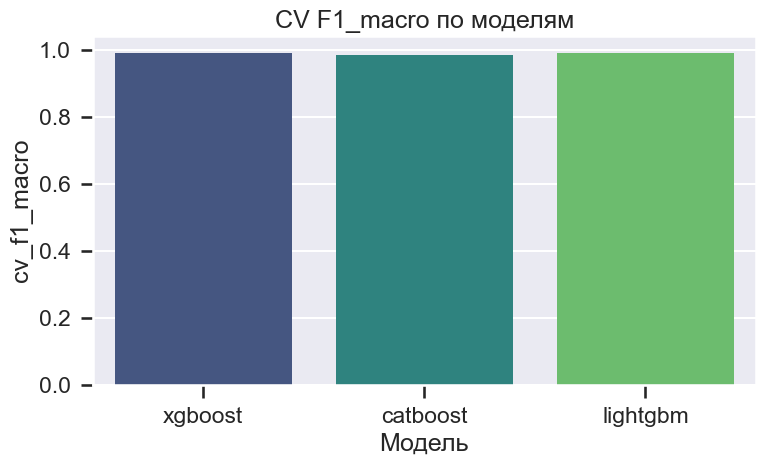

Сохранено: C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\06_reports\cv_f1_macro.png


C:\Users\Shchurov\AppData\Local\Temp\ipykernel_13404\3087244069.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="model", y=value_col, palette="viridis")


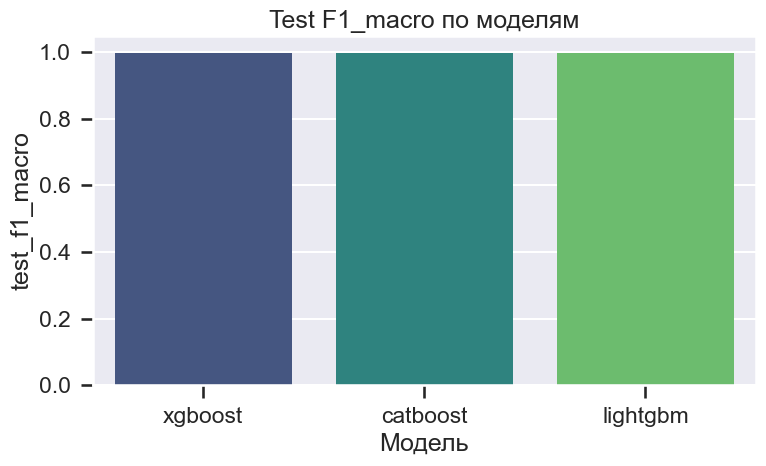

Сохранено: C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\06_reports\test_f1_macro.png


C:\Users\Shchurov\AppData\Local\Temp\ipykernel_13404\3087244069.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="model", y=value_col, palette="viridis")


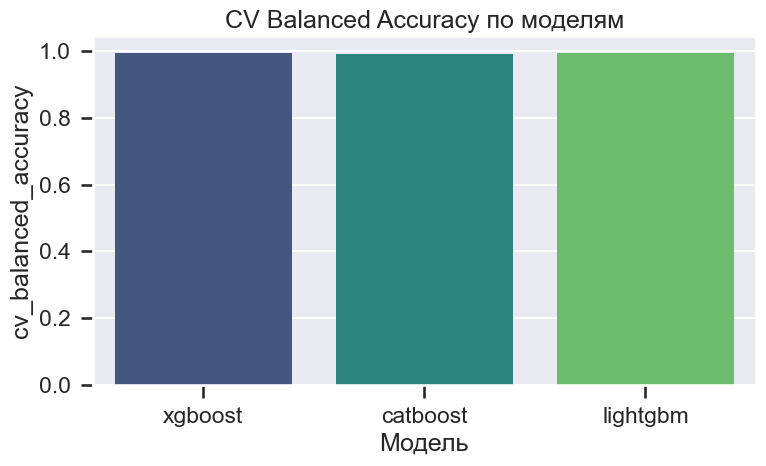

Сохранено: C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\06_reports\cv_bal_acc.png


C:\Users\Shchurov\AppData\Local\Temp\ipykernel_13404\3087244069.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="model", y=value_col, palette="viridis")


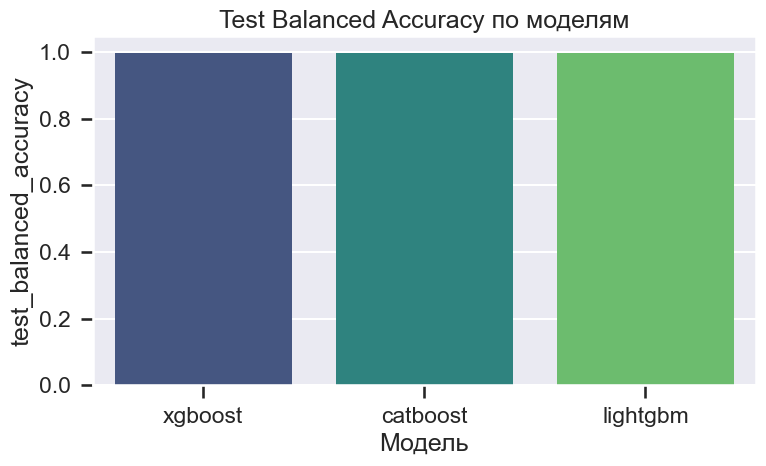

Сохранено: C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\06_reports\test_bal_acc.png


In [7]:
def plot_bar(df: pd.DataFrame, value_col: str, title: str, fname: str):
    plt.figure(figsize=(8, 5))
    sns.barplot(data=df, x="model", y=value_col, palette="viridis")
    plt.title(title)
    plt.xlabel("Модель")
    plt.ylabel(value_col)
    plt.tight_layout()
    out_path = REPORTS_DIR / fname
    plt.savefig(out_path, dpi=150)
    plt.show()
    print(f"Сохранено: {out_path}")

plot_bar(summary_df, "cv_f1_macro", "CV F1_macro по моделям", "cv_f1_macro.png")
plot_bar(summary_df, "test_f1_macro", "Test F1_macro по моделям", "test_f1_macro.png")

# Дополнительно (при необходимости):
plot_bar(summary_df, "cv_balanced_accuracy", "CV Balanced Accuracy по моделям", "cv_bal_acc.png")
plot_bar(summary_df, "test_balanced_accuracy", "Test Balanced Accuracy по моделям", "test_bal_acc.png")


## 7. Детальный разбор ошибок (Confusion Matrix)

Для каждой модели визуализируем матрицу ошибок по тестовой выборке, чтобы понять, где модель чаще всего ошибается (перепутывает классы).


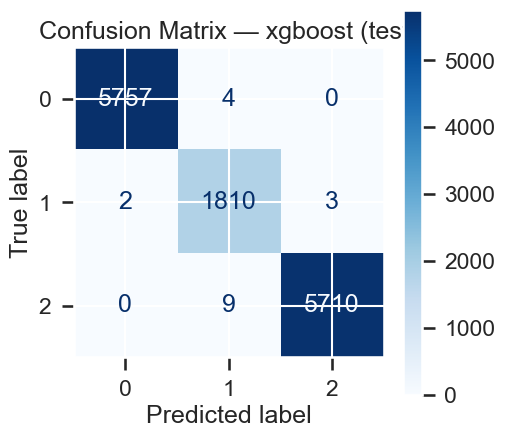

Сохранено: C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\06_reports\cm_xgboost.png


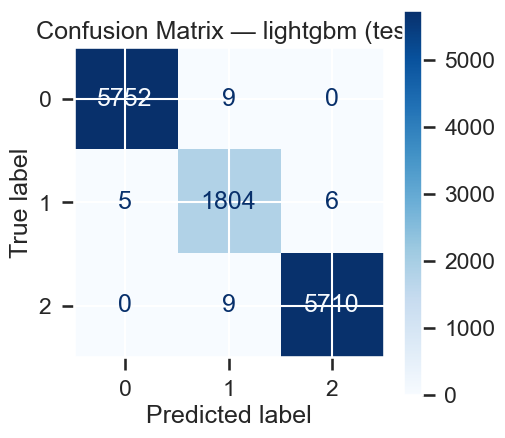

Сохранено: C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\06_reports\cm_lightgbm.png


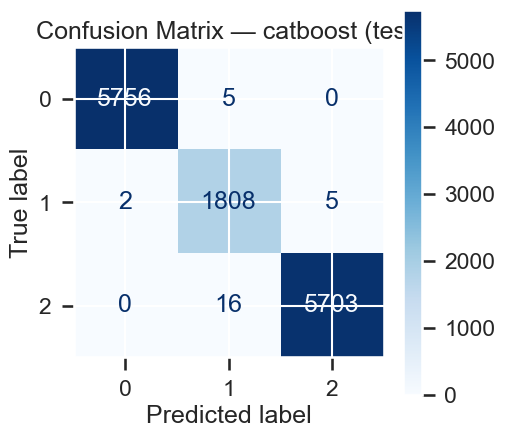

Сохранено: C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\06_reports\cm_catboost.png


In [8]:
from sklearn.metrics import ConfusionMatrixDisplay

for model_name, payload in results.items():
    details = payload.get("test_details", {})
    cm = np.array(details.get("confusion_matrix"))
    if cm.size == 0:
        continue
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
    fig, ax = plt.subplots(figsize=(5, 5))
    disp.plot(ax=ax, cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix — {model_name} (test)")
    out_path = REPORTS_DIR / f"cm_{model_name}.png"
    plt.savefig(out_path, dpi=150)
    plt.show()
    print(f"Сохранено: {out_path}")


## 8. Сохранение окружения эксперимента и резюме

- Сохраним версии ключевых пакетов и случайное зерно
- Сформируем краткое резюме результатов (лучшая модель по F1_macro на тесте)
- Сохраним артефакты в `06_reports`


In [10]:
env_info = {
    "numpy": np.__version__,
    "pandas": pd.__version__,
    "seed": 42,
}

best_row = summary_df.sort_values(by=["test_f1_macro"], ascending=False).head(1)
resume = {
    "best_model": best_row["model"].iloc[0] if not best_row.empty else None,
    "best_test_f1_macro": float(best_row["test_f1_macro"].iloc[0]) if not best_row.empty else None,
}

with open(REPORTS_DIR / "env_and_resume.json", "w", encoding="utf-8") as f:
    json.dump({"env": env_info, "resume": resume}, f, ensure_ascii=False, indent=2)

print("Сохранено:", REPORTS_DIR / "env_and_resume.json")
resume


Сохранено: C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\06_reports\env_and_resume.json


{'best_model': 'xgboost', 'best_test_f1_macro': 0.9978272360234236}